In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation 
import pickle
import sys, os
sys.path.insert(0, os.path.join("..", "source"))
import mass_spring_model
from simulation_util import SummaryFunctions

# Baseline heatmap of average velocities at equilibrium

In [116]:
files = []; path = os.path.join("..", "data", "sweeps", "10_10_2022", "baseline_tc_ds")
for file in os.listdir(path):
    if file.endswith(".p"):
        files.append(file)
data = []
for f in files:
    arr = pickle.load(open(os.path.join(path, f), "rb"))
    par = f[10:-2].split("_")
    avg_speed_last = np.mean([[x[1] for x in r] for r in arr])
    #avg_speed_last = np.mean(np.array([[x[1] for x in r] for r in arr]),axis=0)[-1]
    data.append((round(float(par[0][:-2])), round(float(par[1][:-2])*100), avg_speed_last))

In [117]:
heatmap = np.zeros((3,31))
for d in data:
    heatmap[d[0],d[1]] = d[2]

In [124]:
fig, ax = plt.subplots(2,1,figsize=(18,10))
ax[0].set_xlabel("learning step (ds)",fontsize=16); ax[0].set_ylabel("transient cycles (tc)",fontsize=16)
ax[0].set_title("30 simulations à 2400 sec, average x-velocity towards light [mm/s]",fontsize=22)  # TODO: unit, learning cycles
ax[0].set_xticks(np.arange(0,31,5),labels=np.arange(0,31,5)/100)
for x in range(len(heatmap[0])):
    for y in range(len(heatmap)):
        ax[0].text(x-0.35, y, f"{round(heatmap[y,x]*1000,2):.2f}")
ax[0].imshow(heatmap)
ax[1].plot(np.transpose(heatmap)); ax[1].set_title("same data shown as line plot",fontsize=22)
ax[1].set_xlabel("learning step (ds)",fontsize=16)
ax[1].set_ylabel("transient cycles (tc)",fontsize=16)
ax[1].legend(["tc = 0","tc = 1","tc = 2"])
ax[1].set_xticks(np.arange(0,31,5),labels=np.arange(0,31,5)/100)
fig.savefig("baseline.jpg",format="jpg",dpi=1200)

# Heterogeneity triangle configuration varying ds

## Preprocessing

In [93]:
files = []; path = os.path.join("..", "data", "sweeps", "18_10_2022", "triangle_ds")
for file in os.listdir(path):
    if file.endswith(".p"): files.append(file)
file_info = pd.DataFrame(list(map(lambda x: [float(x[0][0]),float(x[0][1]),float(x[0][2][:-2]),float(x[0][3][:-5]),x[1]], 
    [(f.split("_")[2:],f) for f in files])),columns=["dsL","dsR","dsM","ang","filename"])
len(file_info)

52

In [94]:
def get_ensemble(filepath, num_units=3, num_nodes=8):
    ensemble_data = pickle.load(open(filepath,"rb"))
    headers = ["t"] + np.array([[f"phi {i}", f"mem. phi {i}", f"score {i}",
        f"mem. score {i}", f"learn cycle {i}", f"ds {i}", f"tcl {i}", f"A {i}"] 
        for i in range(num_units)]).flatten().tolist() + np.array([[f"x{i}", f"y{i}"]
        for i in range(num_nodes)]).flatten().tolist()
    return [pd.DataFrame(x, columns=headers) for x in ensemble_data]

In [95]:
def diff(lst, a=np.pi): # successive differences in R/[-a,a] ("else 0" is an approxiamtion)
    return [lst[i]-lst[i-1] if abs(lst[i]-lst[i-1])<a else 0 for i in range(1,len(lst))]

def v_x_angle(df, num_nodes=8, init_angle=5/4 * np.pi):
    sol_col = np.array([[f"x{i}", f"y{i}"] for i in range(num_nodes)]).flatten().tolist()
    df = df.assign(comx=df[sol_col[::2]].mean(axis=1),comy=df[sol_col[1::2]].mean(axis=1))
    df = df.assign(vx=[0] + [(df.comx[i]-df.comx[i-1])/(df.t[i]-df.t[i-1]) for i in range(1,len(df.comx))])
    shifted = np.array([x.to_numpy()-df[["comx","comy"]].to_numpy() for x in np.split(df[sol_col],num_nodes,axis=1)])
    df = df.assign(angle=np.rad2deg((init_angle - np.mean([np.unwrap([np.arctan2(*r)-np.arctan2(*v[0]) for r in v]) 
                                               for v in shifted],axis=0))%(2*np.pi)))
    return df[["t","comx","comy","vx","angle"]]

In [96]:
def to_avg_bins(df, measurement_times):
    df = df.assign(tidx=np.digitize(df["t"], measurement_times)).groupby("tidx").mean()
    empty = pd.DataFrame(columns=df.columns,index=np.arange(1,len(measurement_times)))
    return pd.concat([df, empty[empty.index.isin(df.index) == False]]).sort_index()

def avg_v_x_angle(ensemble, measurement_times):
    return pd.DataFrame(np.array([to_avg_bins(x, measurement_times).to_numpy() for x in ensemble]).mean(axis=0),
                         columns=["t","comx","comy","vx","angle"])

In [97]:
dataframes = []
for i in range(len(file_info)):
    dataframes.append([v_x_angle(x,init_angle=np.deg2rad(file_info.loc[i][3])) 
                       for x in get_ensemble(os.path.join(path,file_info.loc[i][4]))])

In [98]:
avg_data = [avg_v_x_angle(df_lst,np.linspace(0,3000,11)) for df_lst in dataframes]

## Middle ds fixed to 0.04

Note: the maximum theoretically possible velocity for this configuration is:

In [99]:
VMAX = 0.0017112  # in m/s

### Heatmaps

In [129]:
def heatmap(file_subset, extract_func,vary_cols=["dsL","dsR"], symm=False, avg=avg_data):
    grd = zip(file_subset[vary_cols].to_numpy(), file_subset.index)
    cdct = {0.0: 0, 0.01: 1, 0.04: 2, 0.16: 3}; hm = np.zeros((4,4))
    for xy, i in grd:
        hm[cdct[xy[1]],cdct[xy[0]]] = extract_func(avg[i])
    if symm:  # artificial symmetrisation because separately generated files sometimes don't exactly match (but are generally close together)
        hm = (hm.T + hm)/2
    return hm

def hm_plot(hm,xlabel,ylabel,title,ax):
    im = ax.imshow(hm)
    ax.set_xticks(np.arange(hm.shape[0]), labels=[0.0,0.01,0.04,0.16]); 
    ax.set_yticks(np.arange(hm.shape[1]), labels=[0.0,0.01,0.04,0.16])
    for i in range(hm.shape[0]):
        for j in range(hm.shape[1]):
            text = ax.text(j, i, f"{str(hm[i,j]):.5}", ha="center", va="center")
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title);

In [130]:
files1 = file_info[(file_info["dsM"] == 0.04) & (file_info["ang"] == 225.0)]
files2 = file_info[(file_info["dsM"] == 0.04) & (file_info["ang"] == 45.0)]

In [131]:
fig, ax = plt.subplots(2,2,figsize=(10,10)) 
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[-1]["vx"]*1000,3),symm=True),"ds left","ds right","avg. vx [mm/s], 2700-3000s, 225°",ax[0,0])
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[5]["vx"]*1000,3),symm=True),"ds left","ds right","avg vx [mm/s], 1500-1800s, 225°",ax[1,0])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[-1]["vx"]*1000,3),symm=True),"ds left","ds right","avg vx [mm/s], 2700-3000s, 45°",ax[0,1])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[5]["vx"]*1000,3),symm=True),"ds left","ds right","avg vx [mm/s], 1500-1800s, 45°",ax[1,1])

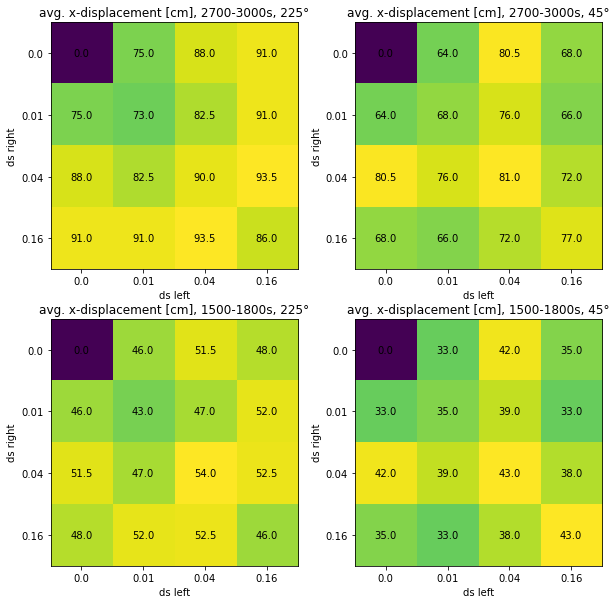

In [132]:
fig, ax = plt.subplots(2,2,figsize=(10,10)) 
hm_plot(heatmap(files1, lambda x: int(x.iloc[-1]["comx"]*100),symm=True),"ds left","ds right","avg. x-displacement [cm], 2700-3000s, 225°",ax[0,0])
hm_plot(heatmap(files1, lambda x: int(x.iloc[5]["comx"]*100),symm=True),"ds left","ds right","avg. x-displacement [cm], 1500-1800s, 225°",ax[1,0])
hm_plot(heatmap(files2, lambda x: int(x.iloc[-1]["comx"]*100),symm=True),"ds left","ds right","avg. x-displacement [cm], 2700-3000s, 45°",ax[0,1])
hm_plot(heatmap(files2, lambda x: int(x.iloc[5]["comx"]*100),symm=True),"ds left","ds right","avg. x-displacement [cm], 1500-1800s, 45°",ax[1,1])

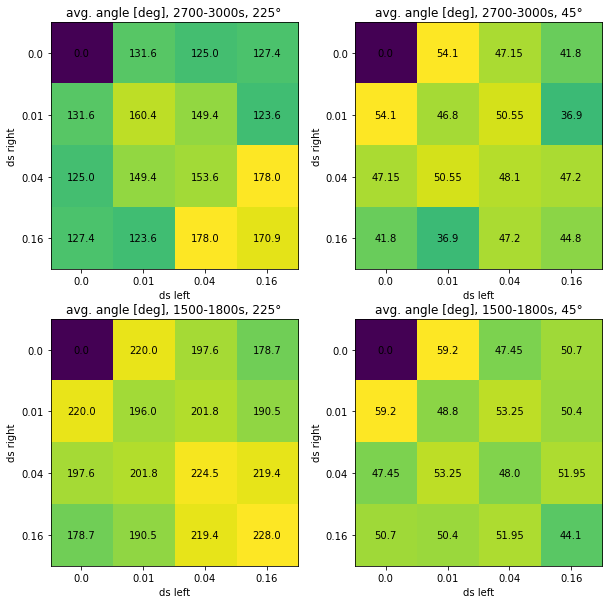

In [104]:
fig, ax = plt.subplots(2,2,figsize=(10,10)) 
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[-1]["angle"],1),symm=True),"ds left","ds right","avg. angle [deg], 2700-3000s, 225°",ax[0,0])
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[5]["angle"],1),symm=True),"ds left","ds right","avg. angle [deg], 1500-1800s, 225°",ax[1,0])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[-1]["angle"],1),symm=True),"ds left","ds right","avg. angle [deg], 2700-3000s, 45°",ax[0,1])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[5]["angle"],1),symm=True),"ds left","ds right","avg. angle [deg], 1500-1800s, 45°",ax[1,1])

### Velocity heatmap from above relative to maximum velocity

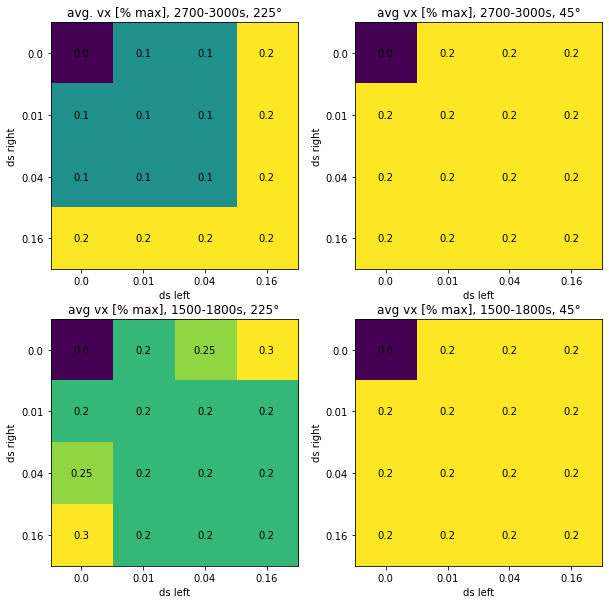

In [105]:
fig, ax = plt.subplots(2,2,figsize=(10,10)) 
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[-1]["vx"]/VMAX,1),symm=True),"ds left","ds right","avg. vx [% max], 2700-3000s, 225°",ax[0,0])
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[5]["vx"]/VMAX,1),symm=True),"ds left","ds right","avg vx [% max], 1500-1800s, 225°",ax[1,0])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[-1]["vx"]/VMAX,1),symm=True),"ds left","ds right","avg vx [% max], 2700-3000s, 45°",ax[0,1])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[5]["vx"]/VMAX,1),symm=True),"ds left","ds right","avg vx [% max], 1500-1800s, 45°",ax[1,1])

### Distributions

In [140]:
def vln_plt(ensemble,colname,n,xlabel,ylabel,title,ax,ylim=(-0.2,1.0),mul=1000):
    ax.violinplot(np.array([to_avg_bins(sim,np.linspace(0,3000,n+1))[colname].to_numpy()*mul for sim in ensemble]).astype(float),showmeans=True)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.set_xticks(np.arange(1,n+1),labels=(np.arange(1,n+1)*3000/n).astype(int)); ax.set_ylim(*ylim)

In [138]:
dsr, dsl, dsm = 0.16, 0.0, 0.04; fls = file_info[(file_info.dsL==dsl) & (file_info.dsR==dsr) & (file_info.dsM==dsm)].sort_values("ang")
ex_cmp = [dataframes[i] for i in fls.index]

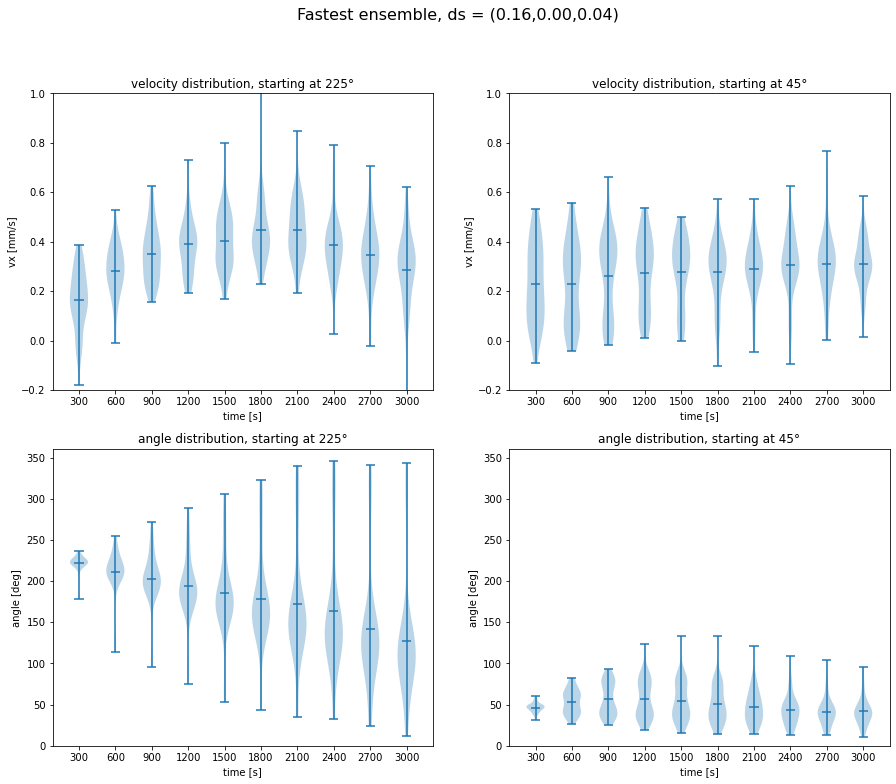

In [153]:
fig, ax = plt.subplots(2,2,figsize=(15,12))
fig.suptitle("Fastest ensemble, ds = (0.16,0.00,0.04)",fontsize=16)
vln_plt(ex_cmp[0],"vx",10,"time [s]","vx [mm/s]","velocity distribution, starting at 45°", ax[0,1])
vln_plt(ex_cmp[1],"vx",10,"time [s]","vx [mm/s]","velocity distribution, starting at 225°", ax[0,0])
vln_plt(ex_cmp[0],"angle",10,"time [s]","angle [deg]","angle distribution, starting at 45°", ax[1,1],(0,360),1)
vln_plt(ex_cmp[1],"angle",10,"time [s]","angle [deg]","angle distribution, starting at 225°", ax[1,0],(0,360),1)
plt.show()
fig.savefig("fastest_distributions.jpg",format="jpg",dpi=1200)
#print(np.mean([to_avg_bins(x,np.linspace(0,3000,11))["vx"].to_numpy()[-1] for x in ex_cmp[0]]))
#print(np.mean([to_avg_bins(x,np.linspace(0,3000,11))["vx"].to_numpy()[-1] for x in ex_cmp[1]]))

### Individual Path Plots

In [46]:
def angl_paths(ensemble,n,ax,title):
    angle_arr = [to_avg_bins(ensemble[i],np.linspace(0,3000,n+1))["angle"].to_numpy() for i in range(50)]
    cmap = colormaps["winter"]; idx = np.linspace(0,1,len(angle_arr))
    [ax.plot(angle_arr[i], color=cmap(idx[i])) for i in range(len(angle_arr))] 
    ax.set_title(title); ax.set_xlabel("time [s]"); ax.set_ylabel("angle [deg]")
    ax.set_xticks(np.arange(n), labels=((np.arange(n)+1)*3000/n).astype(int))

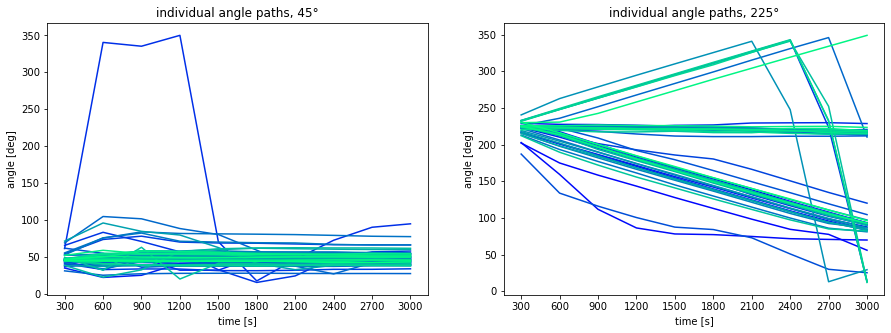

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
angl_paths(ex_cmp[0],10,ax[0],"individual angle paths, 45°")
angl_paths(ex_cmp[1],10,ax[1],"individual angle paths, 225°")

In [48]:
def path_dist(ensemble,n,ax,title):
    ax.set_title(title); ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]")
    cmap = colormaps["winter"]; idx = np.linspace(0,1,len(ensemble))
    [ax.scatter(*np.transpose(ensemble[i][["comx","comy"]].to_numpy()),s=0.05,color=cmap(idx[i])) for i in range(len(ensemble))]

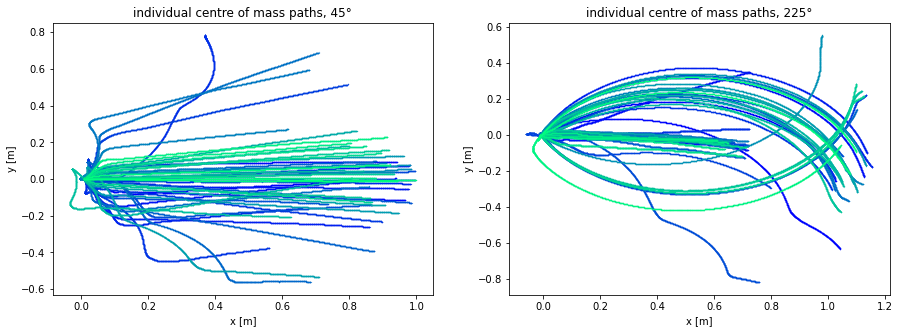

In [49]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
path_dist(ex_cmp[0],10,ax[0],"individual centre of mass paths, 45°")
path_dist(ex_cmp[1],10,ax[1],"individual centre of mass paths, 225°")

### Animating movement

In [50]:
def animation(position_data, framerate=10, size=((-0.2,1.2),(-0.5,0.5))):
    elements = [(0, 1), (0, 2), (2, 3), (1, 3), (0, 3), (1, 2), (4, 5), (4, 1), (1, 6), (5, 6), (4, 6), (5, 1), (3, 7), (6, 7), (1, 7), (6, 3)]
    fig = plt.figure(); #TODO: add time please
    ax = plt.axes(xlim=size[0], ylim=size[1]) 
    ax.set_aspect(1)
    lines = [plt.plot([], [], lw=2, marker='o', c="g", zorder=3)[0] for _ in range(len(elements))]
    plt.grid(True, linestyle='-.')
    def animate(i): 
        U = position_data[i*framerate,-16:]
        for i, el in enumerate(elements): 
            lines[i].set_data([U[2*el[0]], U[2*el[1]]], [U[2*el[0]+1], U[2*el[1]+1]])
    ani = FuncAnimation(fig,animate,frames=len(position_data)//framerate)
    from IPython.display import HTML
    return HTML(ani.to_jshtml())

def draw_configuration(U, size=((-0.2,1.2),(-0.2,0.8))): 
    elements = [(0, 1), (0, 2), (2, 3), (1, 3), (0, 3), (1, 2), (4, 5), (4, 1), (1, 6), (5, 6), (4, 6), (5, 1), (3, 7), (6, 7), (1, 7), (6, 3)]
    fig = plt.figure(); 
    ax = plt.axes(xlim=size[0], ylim=size[1]) 
    ax.set_aspect(1)
    lines = [plt.plot([], [], lw=2, marker='o', c="g", zorder=3)[0] for _ in range(len(elements))]
    plt.grid(True, linestyle='-.')
    for i, el in enumerate(elements): 
        lines[i].set_data([U[2*el[0]], U[2*el[1]]], [U[2*el[0]+1], U[2*el[1]+1]])

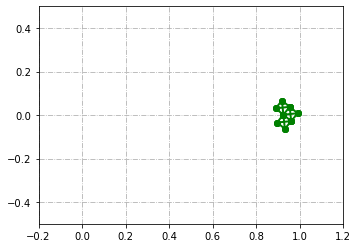

In [51]:
animation(pickle.load(open(os.path.join(path,fls.loc[fls.index[0]]["filename"]),"rb"))[0][:,-16:])

## Right ds fixed to 0.04 (not symmetric in dsL and dsM!)

In [52]:
files1 = file_info[(file_info["dsR"] == 0.04) & (file_info["ang"] == 225.0)]
files2 = file_info[(file_info["dsR"] == 0.04) & (file_info["ang"] == 45.0)]

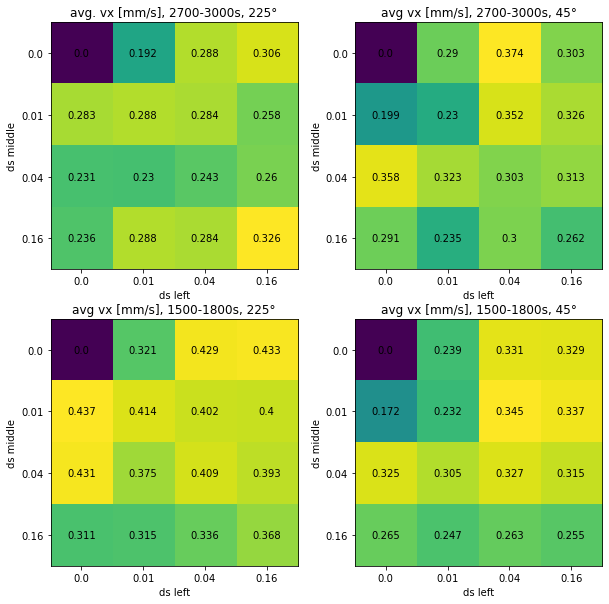

In [53]:
fig, ax = plt.subplots(2,2,figsize=(10,10)) 
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[-1]["vx"]*1000,3), ["dsL","dsM"]),"ds left","ds middle","avg. vx [mm/s], 2700-3000s, 225°",ax[0,0])
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[5]["vx"]*1000,3),["dsL","dsM"]),"ds left","ds middle","avg vx [mm/s], 1500-1800s, 225°",ax[1,0])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[-1]["vx"]*1000,3),["dsL","dsM"]),"ds left","ds middle","avg vx [mm/s], 2700-3000s, 45°",ax[0,1])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[5]["vx"]*1000,3),["dsL","dsM"]),"ds left","ds middle","avg vx [mm/s], 1500-1800s, 45°",ax[1,1])

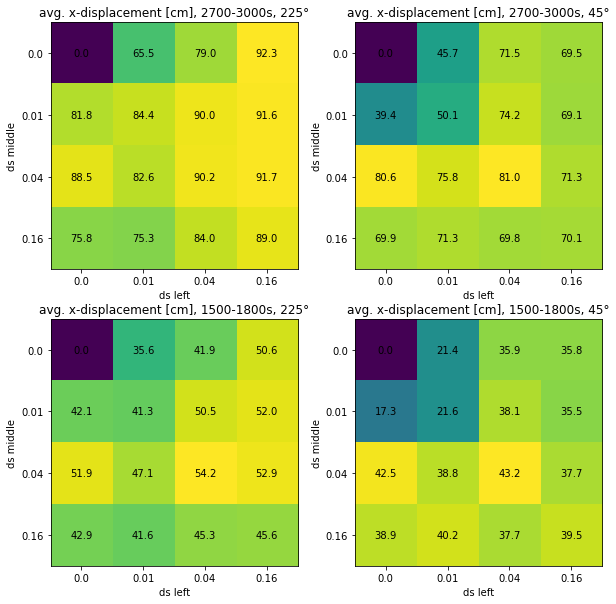

In [54]:
fig, ax = plt.subplots(2,2,figsize=(10,10))  # TODO 
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[-1]["comx"]*100,1),["dsL","dsM"]),"ds left","ds middle","avg. x-displacement [cm], 2700-3000s, 225°",ax[0,0])
hm_plot(heatmap(files1, lambda x: np.round(x.iloc[5]["comx"]*100,1),["dsL","dsM"]),"ds left","ds middle","avg. x-displacement [cm], 1500-1800s, 225°",ax[1,0])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[-1]["comx"]*100,1),["dsL","dsM"]),"ds left","ds middle","avg. x-displacement [cm], 2700-3000s, 45°",ax[0,1])
hm_plot(heatmap(files2, lambda x: np.round(x.iloc[5]["comx"]*100,1),["dsL","dsM"]),"ds left","ds middle","avg. x-displacement [cm], 1500-1800s, 45°",ax[1,1])

In [55]:
dsr, dsl, dsm = 0.04, 0.0, 0.16; fls = file_info[(file_info.dsL==dsl) & (file_info.dsR==dsr) & (file_info.dsM==dsm)].sort_values("ang")
ex_cmp = [dataframes[i] for i in fls.index]

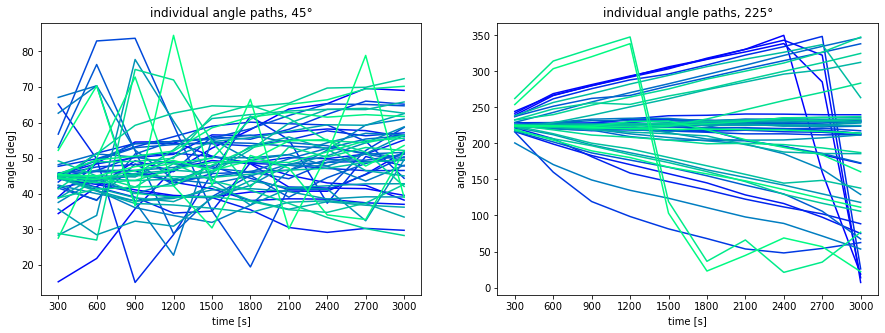

In [56]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
angl_paths(ex_cmp[0],10,ax[0],"individual angle paths, 45°")
angl_paths(ex_cmp[1],10,ax[1],"individual angle paths, 225°")

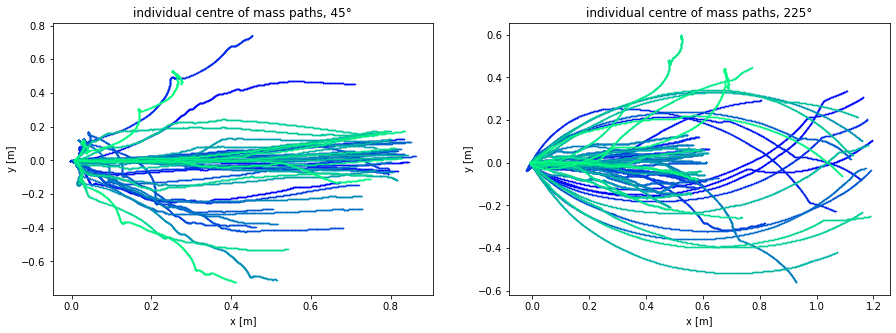

In [57]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
path_dist(ex_cmp[0],10,ax[0],"individual centre of mass paths, 45°")
path_dist(ex_cmp[1],10,ax[1],"individual centre of mass paths, 225°")

## Candidates for Fastest

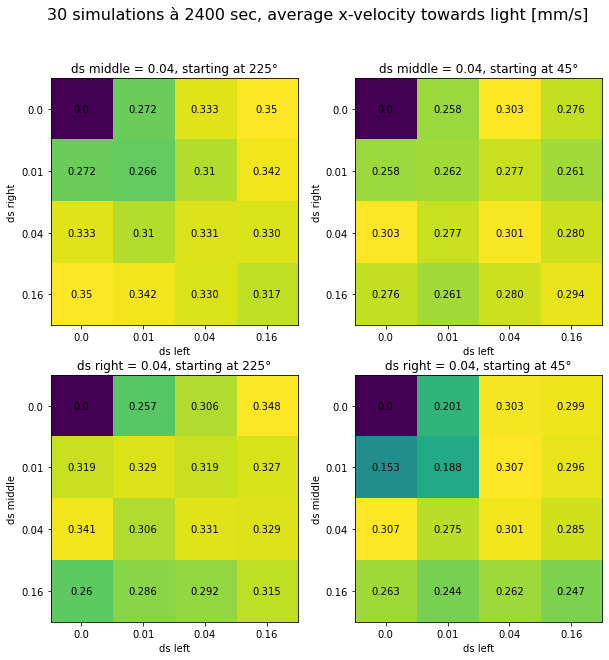

In [137]:
files1 = file_info[(file_info["dsM"] == 0.04) & (file_info["ang"] == 225.0)]
files2 = file_info[(file_info["dsM"] == 0.04) & (file_info["ang"] == 45.0)]
files3 = file_info[(file_info["dsR"] == 0.04) & (file_info["ang"] == 225.0)]
files4 = file_info[(file_info["dsR"] == 0.04) & (file_info["ang"] == 45.0)]
fig, ax = plt.subplots(2,2,figsize=(10,10)) 
fig.suptitle("30 simulations à 2400 sec, average x-velocity towards light [mm/s]",fontsize=16)
hm_plot(heatmap(files1, lambda x: np.round(x["vx"].mean()*1000,3),symm=True),"ds left","ds right","ds middle = 0.04, starting at 225°",ax[0,0])
hm_plot(heatmap(files2, lambda x: np.round(x["vx"].mean()*1000,3),symm=True),"ds left","ds right","ds middle = 0.04, starting at 45°",ax[0,1])
hm_plot(heatmap(files3, lambda x: np.round(x["vx"].mean()*1000,3),["dsL","dsM"]),"ds left","ds middle","ds right = 0.04, starting at 225°",ax[1,0])
hm_plot(heatmap(files4, lambda x: np.round(x["vx"].mean()*1000,3),["dsL","dsM"]),"ds left","ds middle","ds right = 0.04, starting at 45°",ax[1,1])
fig.savefig("heatmaps_ds.jpg",format="jpg",dpi=1200)

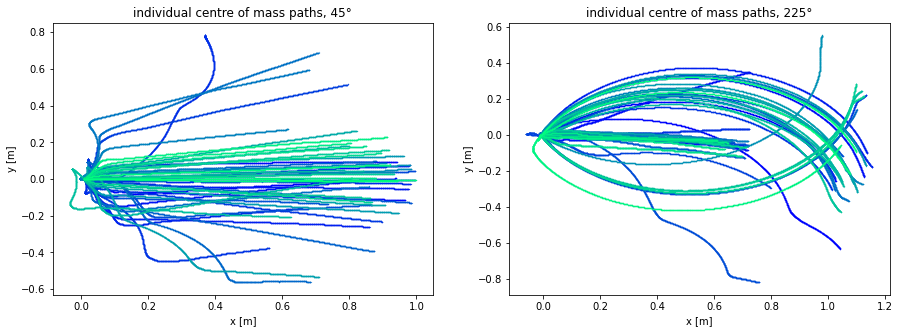

In [59]:
dsr, dsl, dsm = 0.04, 0.00, 0.04; fls = file_info[(file_info.dsL==dsl) & (file_info.dsR==dsr) & (file_info.dsM==dsm)].sort_values("ang")
ex_cmp = [dataframes[i] for i in fls.index]
fig, ax = plt.subplots(1,2,figsize=(15,5))
path_dist(ex_cmp[0],10,ax[0],"individual centre of mass paths, 45°")
path_dist(ex_cmp[1],10,ax[1],"individual centre of mass paths, 225°")

In [ ]:
# check amplitude effect first (then learning of learning step), 
# (step size matters more fore large systems, amplitude already before)
# 225 + homogeneous ds (const. )
# needs to be twice as long
# influence of transient cycles (amplified learning? turning?) fast turning? 
# take slightly more complex shape: compare some heterogeneous points of heatmap 
# and see whether equilibrium are different 

# 15 Transient Cycles (very long)

In [44]:
files2 = []; path2 = os.path.join("..", "data", "sweeps", "24_10_2022", "triangle_ds_2")
for file in os.listdir(path2):
    if file.endswith(".p"): files2.append(file)
file_info2 = pd.DataFrame(list(map(lambda x: [float(x[0][0]),float(x[0][1]),float(x[0][2][:-2]),float(x[0][3][:-5]),x[1]], 
    [(f.split("_")[2:],f) for f in files2])),columns=["dsL","dsR","dsM","ang","filename"])
len(file_info2)

19

In [45]:
files12 = file_info2[(file_info2["dsM"] == 0.04) & (file_info2["ang"] == 225.0)]
#files2 = file_info[(file_info["dsM"] == 0.04) & (file_info["ang"] == 45.0)]

In [61]:
dataframes2 = []
for i in range(len(file_info2)):
    dataframes2.append([v_x_angle(x,init_angle=np.deg2rad(file_info2.loc[i][3])) 
                       for x in get_ensemble(os.path.join(path2,file_info2.loc[i][4]))])

In [172]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
def colour_path_plt(df,ax,no_light=False,size=100,markerSize=100):
    cmap = colormaps["hsv"]; idx = np.linspace(0,1,360)[df.angle.astype(int)]
    scat = ax.scatter(df.comx,df.comy,s=size,c=cmap(idx))
    if not no_light:
        switch = np.where(np.concatenate([df.light_x.to_numpy()[1:] != df.light_x.to_numpy()[:-1], [False]]))[0]
        ax.scatter(df.comx[switch], df.comy[switch],s=markerSize,c='black',marker="*")
    ax.scatter(df.comx[0], df.comy[0],s=markerSize,c='black',marker=">")
    ax.set_aspect(1)
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax,cmap=cmap,norm=Normalize(vmin=0,vmax=360),ticks=np.arange(19)*20).set_label("angle [deg]")

In [46]:
avg_data2 = [avg_v_x_angle(df_lst,np.linspace(0,3000,11)) for df_lst in dataframes2]

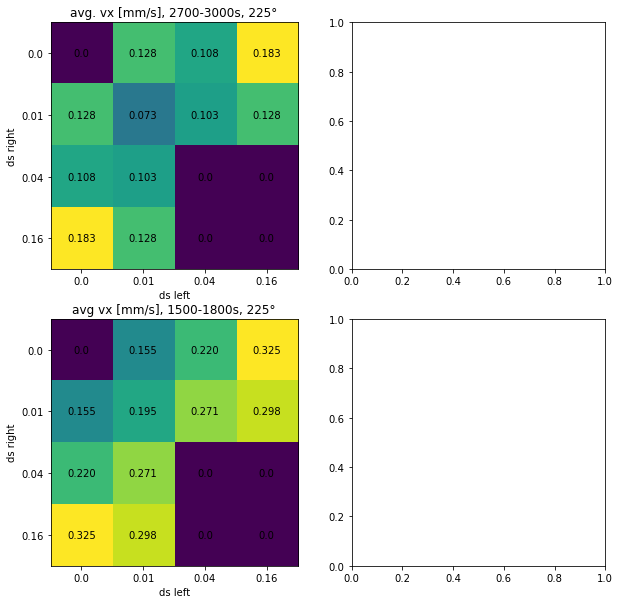

In [74]:
fig, ax = plt.subplots(2,2,figsize=(10,10)) 
hm_plot(heatmap(files12, lambda x: np.round(x.iloc[-1]["vx"]*1000,3),symm=True,avg=avg_data2),"ds left","ds right","avg. vx [mm/s], 2700-3000s, 225°",ax[0,0])
hm_plot(heatmap(files12, lambda x: np.round(x.iloc[5]["vx"]*1000,3),symm=True,avg=avg_data2),"ds left","ds right","avg vx [mm/s], 1500-1800s, 225°",ax[1,0])
#hm_plot(heatmap(files2, lambda x: np.round(x.iloc[-1]["vx"]*1000,3),symm=True),"ds left","ds right","avg vx [mm/s], 2700-3000s, 45°",ax[0,1])
#hm_plot(heatmap(files2, lambda x: np.round(x.iloc[5]["vx"]*1000,3),symm=True),"ds left","ds right","avg vx [mm/s], 1500-1800s, 45°",ax[1,1])

In [155]:
dsr, dsl, dsm = 0.01, 0.01, 0.04; fls = file_info2[(file_info2.dsL==dsl) & (file_info2.dsR==dsr) & (file_info2.dsM==dsm)].sort_values("ang")
ex_cmp = [dataframes2[i] for i in fls.index]

NameError: name 'path_dist' is not defined

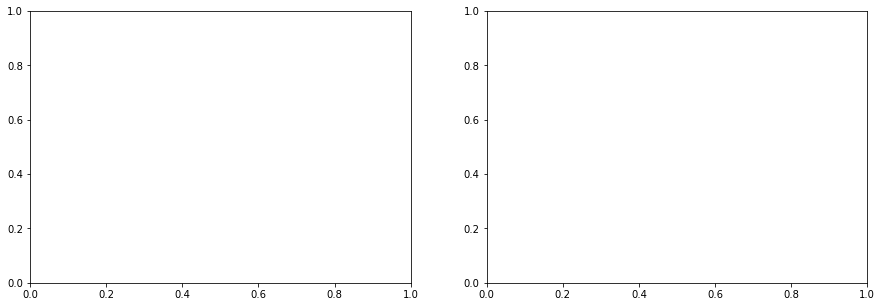

In [156]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
path_dist(ex_cmp[0],10,ax[0],"individual centre of mass paths, 45°")
#path_dist(ex_cmp[1],10,ax[1],"individual centre of mass paths, 225°")

In [157]:
ex_cmp

[[               t      comx      comy        vx       angle
  0         2.8752 -0.008050 -0.000462  0.000000  225.000000
  1         3.1536 -0.008238 -0.000750 -0.000673  225.472584
  2         3.5517 -0.008212 -0.000813  0.000063  225.714974
  3         4.8746 -0.008175 -0.001175  0.000028  225.034629
  4         5.1533 -0.008362 -0.001450 -0.000673  225.515311
  ...          ...       ...       ...       ...         ...
  1795  10169.4465  1.976175  0.543325  0.000177  240.066646
  1796  10169.9982  1.976075  0.543325 -0.000181  240.072280
  1797  10170.8803  1.976513  0.543438  0.000496  240.053033
  1798  10171.4467  1.976650  0.543463  0.000243  240.060653
  1799  10171.9982  1.976562  0.543450 -0.000159  240.048162
  
  [1800 rows x 5 columns],
                 t      comx      comy        vx       angle
  0         2.0050 -0.008137  0.000125  0.000000  225.000000
  1         2.8504 -0.008387 -0.000388 -0.000296  226.348470
  2         3.8535 -0.008275 -0.000088  0.000112  225.1

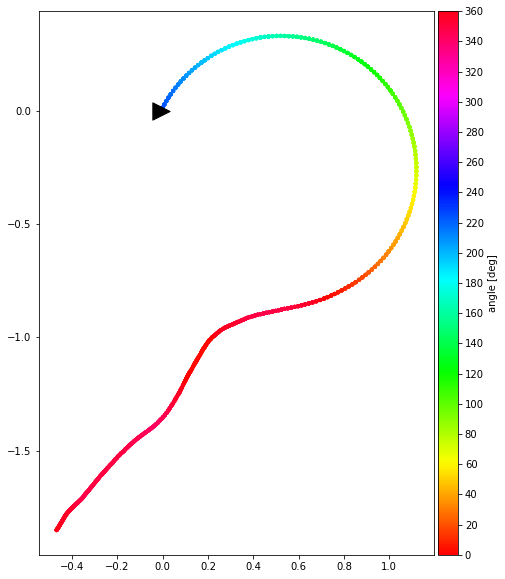

In [176]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
colour_path_plt(ex_cmp[0][8],ax,no_light=True,size=10,markerSize=300)
fig.savefig("long_tc_misguided.jpg",format="jpg",dpi=1200)